# Machine Translation + Transformer

<img src = "../figures/transformer1.png" >

# Machine Translation with Transformer Models

This project develops a machine translation system using Transformer models to translate between English and Bengali. It focuses on implementing different attention mechanisms to enhance translation quality. Below are the details of dataset preparation, model implementation, and experimentation with attention mechanisms.

## Task 1: Get Language Pair

### Dataset Selection
- **Source**: OPUS-100 Corpus
- **Language Pair**: English and Bengali
- **Credit**: The dataset is sourced from [OPUS-100 Corpus](https://opus.nlpl.eu/opus-100.php), and we acknowledge their contribution to making this valuable resource available to the public.

### Dataset Preparation
The dataset preparation involves several key stages, focusing on the specific requirements of English and Bengali languages:

1. **Text Normalization**:
    - For both English and Bengali, we use `spaCy` with the `xx_ent_wiki_sm` model for preliminary text cleaning and normalization.

2. **Tokenization**:
    - `spaCy` and its `xx_ent_wiki_sm` model are employed for tokenizing text in both languages, ensuring accurate segmentation for further processing.

3. **Vocabulary Building**:
    - A comprehensive vocabulary is constructed for each language, including special tokens for sentence management and numerical representation.

4. **Numericalization**:
    - Tokenized text is converted into numeric sequences, aligning with the constructed vocabulary.

5. **Sequence Padding**:
    - Sequences are padded to ensure uniform length within each batch, facilitating efficient model processing.

6. **Batch Preparation**:
    - Prepared sequences are grouped into batches, ready for model training and evaluation.

7. **Attention Masking**:
    - Masks are generated to prevent the model from attending to padded positions, enhancing translation focus and accuracy.

### Tools and Libraries Used
- **spaCy**: Used for text normalization and tokenization, leveraging the multi-language capabilities of the `xx_ent_wiki_sm` model. ([spaCy](https://spacy.io/))
- **PyTorch**: Serves as the primary framework for model implementation and training. ([PyTorch](https://pytorch.org/))


## Further Reading

For an in-depth exploration of attention mechanisms and their implications on neural network models, the following paper provides comprehensive insights: [An Attentive Survey of Attention Models](https://arxiv.org/pdf/1904.02874.pdf).



In [1]:
import torch, torchdata, torchtext
import torch.nn as nn
import torch.nn.functional as F

import random, math, time
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cpu


In [2]:
# torch.cuda.get_device_name(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device) 

cpu


In [3]:
torch.__version__

'2.2.0+cpu'

In [4]:
torchtext.__version__

'0.17.0+cpu'

In [5]:
import spacy
print(spacy.__version__)

3.7.4


## 1. ETL: Loading the dataset

**Note**: Here I chose to translate English to Bangla , As Bangla is my native language. 

In [6]:
from datasets import load_dataset

# Define the source and target languages for translation.
SRC_LANGUAGE = 'en'  # Source language code (English).
TRG_LANGUAGE = 'bn'  # Target language code (Bengali).

# Load the dataset from the OPUS-100 corpus for the specified language pair ("bn-en").
dataset = load_dataset("opus100", "bn-en")


In [7]:
from numpy.random import default_rng
from datasets import Dataset

# Define your dataset's seed for reproducibility across runs.
SEED = 42

# Initialize the random number generator.
ran_rng = default_rng(seed=SEED)

# Specify the number of samples to select.

select_idx = ran_rng.choice(len(dataset['train']), size= 4000, replace=False)

# Filter the training dataset to only include the selected indices.
dataset['train'] = dataset['train'].filter(lambda example, idx: idx in select_idx, with_indices=True)



In [8]:
dataset['train']

Dataset({
    features: ['translation'],
    num_rows: 4000
})

In [9]:
dataset['train']

Dataset({
    features: ['translation'],
    num_rows: 4000
})

In [10]:
# Define a lambda function to extract sentences for a specified language from the dataset's 'translation' dictionary.
lang_cols = lambda example, lang: {lang: example['translation'][lang]}

# Use the lambda function with the dataset's .map() method to extract English sentences from the 'translation' dictionary,
# adding them as a new column in the dataset.
dataset = dataset.map(lang_cols, fn_kwargs={'lang': "en"})
dataset = dataset.map(lang_cols, remove_columns=['translation'], fn_kwargs={'lang': "bn"})



In [11]:
dataset

DatasetDict({
    test: Dataset({
        features: ['en', 'bn'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['en', 'bn'],
        num_rows: 4000
    })
    validation: Dataset({
        features: ['en', 'bn'],
        num_rows: 2000
    })
})

## 2. EDA - simple investigation

In [12]:
import random

def train_test_split(dataset, test_size=0.3, random_state=42):
    """
    Splits a dataset into training and testing sets based on a specified test size ratio.
    
    Parameters:
    - dataset: The dataset to split, expected to be a list or similar iterable.
    - test_size (float): The proportion of the dataset to allocate to the test set.
    - random_state (int): A seed value to ensure reproducibility of the split.

    Returns:
    - train_data (list): The training subset of the dataset.
    - test_data (list): The testing subset of the dataset.
    """
    # Seed the random number generator to ensure reproducible splits
    random.seed(random_state)
    
    # Generate a shuffled list of indices based on the dataset size
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    
    # Calculate the split index to delineate training and testing sets
    split_idx = int(len(dataset) * (1 - test_size))
    
    # Partition the dataset into training and testing sets using the calculated split index
    train_indices, test_indices = indices[:split_idx], indices[split_idx:]
    train_data = [dataset[i] for i in train_indices]
    test_data = [dataset[i] for i in test_indices]

    return train_data, test_data

# Example usage to split the dataset into training and a temporary subset, then further into validation and testing sets
train_data, temp_data = train_test_split(dataset['train'], test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

In [13]:
len(train_data), len(val_data), len(test_data)

(2800, 600, 600)

In [14]:
dataset['train'][0]

{'en': 'The time must be in the format: %s',
 'bn': 'তারিখ যে বিন্যাসে হতে হবে: %s'}

## 3. Preprocessing 

### Tokenizing

Run the command to download the xx_ent_wiki_sm model for spaCy:

python -m spacy download xx_ent_wiki_sm

For the en_core_web_sm model, use the following command:

python -m spacy download en_core_web_sm


In [15]:
# Place-holders
token_transform = {}
vocab_transform = {}

In [16]:
from torchtext.data.utils import get_tokenizer
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TRG_LANGUAGE] = get_tokenizer('spacy', language='xx_ent_wiki_sm')

In [17]:
# test a sample
print("Sentence: ", train_data[1][SRC_LANGUAGE])  
print("Tokenization: ", token_transform[SRC_LANGUAGE](train_data[1][SRC_LANGUAGE]))
print("Tokenization: ", token_transform[TRG_LANGUAGE](train_data[1][TRG_LANGUAGE]))

Sentence:  ‘Million People March’ Against Corruption in the Philippines.
Tokenization:  ['‘', 'Million', 'People', 'March', '’', 'Against', 'Corruption', 'in', 'the', 'Philippines', '.']
Tokenization:  ['দুর্নীতির', 'বিরুদ্ধে', 'ফিলিপাইনে', "'", 'লাখো', 'মানুষের', 'মিছিল', "'"]


A function to tokenize our input.

In [18]:
import logging

def tokenize_data(example, lang):
    # Initialize a logger
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)
    
    try:
        if lang == 'en':  # For English, apply lowercasing before tokenization.
            return {lang: token_transform[lang](example[lang].lower())}
        else:  # For other languages (e.g., Bengali), skip lowercasing.
            return {lang: token_transform[lang](example[lang])}
    except Exception as e:
        logger.error(f"Error tokenizing data: {e}")
        # Fallback behavior in case of an error during tokenization.
        return {lang: []}

# Assuming 'dataset' is your dataset and 'SRC_LANGUAGE' is defined
# Tokenize the dataset for the source language and remove original text columns.
tokenized_dataset = dataset['train'].map(lambda example: tokenize_data(example, SRC_LANGUAGE),
                                         remove_columns=[SRC_LANGUAGE])


In [19]:
tokenized_dataset

Dataset({
    features: ['bn', 'en'],
    num_rows: 4000
})

In [20]:
tokenized_dataset = tokenized_dataset.map(tokenize_data, fn_kwargs={'lang': TRG_LANGUAGE})

In [21]:
tokenized_dataset[SRC_LANGUAGE][1]

['and',
 'do',
 'not',
 'send',
 'away',
 'those',
 'who',
 'call',
 'upon',
 'their',
 'lord',
 'morning',
 'and',
 'afternoon',
 ',',
 'seeking',
 'his',
 'countenance',
 '.',
 'not',
 'upon',
 'you',
 'is',
 'anything',
 'of',
 'their',
 'account',
 'and',
 'not',
 'upon',
 'them',
 'is',
 'anything',
 'of',
 'your',
 'account',
 '.']

In [22]:
tokenized_dataset[TRG_LANGUAGE][1]

['আর',
 'তাদেরকে',
 'বিতাড়িত',
 'করবেন',
 'না',
 ',',
 'যারা',
 'সকাল',
 '-',
 'বিকাল',
 'স',
 '্',
 'বীয়',
 'পালকর',
 '্',
 'তার',
 'এবাদত',
 'করে',
 ',',
 'তাঁর',
 'সন',
 '্',
 'তুষ',
 '্',
 'টি',
 'কামনা',
 'করে',
 '।',
 'তাদের',
 'হিসাব',
 'বিন',
 '্',
 'দুমাত',
 '্',
 'রও',
 'আপনার',
 'দায়িত',
 '্',
 'বে',
 'নয়',
 'এবং',
 'আপনার',
 'হিসাব',
 'বিন',
 '্',
 'দুমাত',
 '্',
 'রও',
 'তাদের',
 'দায়িত',
 '্',
 'বে',
 'নয়',
 'যে',
 ',',
 'আপনি',
 'তাদেরকে',
 'বিতাড়িত',
 'করবেন',
 '।',
 'নতুবা',
 'আপনি',
 'অবিচারকারীদের',
 'অন',
 '্',
 'তর',
 '্',
 'ভূক',
 '্',
 'ত',
 'হয়ে',
 'যাবেন',
 '।']

Before we tokenize, let's define some special symbols so our neural network understand the embeddings of these symbols, namely the unknown, the padding, the start of sentence, and end of sentence.

In [23]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Text to integers (Numericalization)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [24]:
from torchtext.vocab import build_vocab_from_iterator


vocab_transform = {}

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(
        tokenized_dataset[ln],  # This should be an iterator over lists of tokens for each language
        min_freq=3,  # Minimum frequency for a token to be included in the vocabulary
        specials=special_symbols,
        special_first=True  # Indicates whether to insert special symbols at the beginning or at the end
    )

    # Set UNK_IDX as the default index for unknown tokens
    vocab_transform[ln].set_default_index(UNK_IDX)


In [25]:
# Assuming vocab_transform is a dictionary with vocabularies for each language
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    print(f"--- Vocabulary for {ln.upper()} ---")
    print(f"Vocabulary size: {len(vocab_transform[ln])}")

    for token in special_symbols:
        if token in vocab_transform[ln].get_stoi():
            print(f"Special token '{token}' index: {vocab_transform[ln][token]}")
        else:
            print(f"Special token '{token}' not found in vocabulary")


--- Vocabulary for EN ---
Vocabulary size: 2087
Special token '<unk>' index: 0
Special token '<pad>' index: 1
Special token '<sos>' index: 2
Special token '<eos>' index: 3
--- Vocabulary for BN ---
Vocabulary size: 2540
Special token '<unk>' index: 0
Special token '<pad>' index: 1
Special token '<sos>' index: 2
Special token '<eos>' index: 3


In [26]:
#see some example
vocab_transform[SRC_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[107, 13, 11, 0, 11]

In [27]:
#we can reverse it....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()

#print 108, for example
mapping[107]

'here'

In [28]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [29]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [30]:
#check unique vocabularies
len(mapping)

2087

In [31]:
num_samples_to_display = 10  # Define how many samples to display.

# Iterate over both the source and target languages.
for lang in [SRC_LANGUAGE, TRG_LANGUAGE]:  # Assuming SRC_LANGUAGE='en', TRG_LANGUAGE='bn'.
    print(f"--- {lang.upper()} Samples (Original, Tokenized, and Numericalized) ---")
    for i in range(num_samples_to_display):
        # Extract the original text for the current language and sample.
        original_text = dataset['train'][i][lang]

        # Process text: Convert to lowercase for English to ensure consistency in tokenization.
        processed_text = original_text.lower() if lang == 'en' else original_text

        print(f"Original Sample {i+1}: {original_text}")

        # Tokenize the text, yielding a list of tokens.
        tokenized_text = token_transform[lang](processed_text)
        print(f"Tokenized Sample {i+1}: {tokenized_text}")

        # Numericalize the tokenized text, converting tokens to their numerical IDs.
        numericalized_text = [vocab_transform[lang][token] for token in tokenized_text]
        print(f"After Numericalization {i+1}: {numericalized_text}")

        # This step assumes the vocabulary supports ID-to-token conversion.
        if hasattr(vocab_transform[lang], 'lookup_token'):
            tokens_from_ids = [vocab_transform[lang].lookup_token(id) for id in numericalized_text]
        else:
            # Fallback method if 'lookup_token' is not available.
            tokens_from_ids = [vocab_transform[lang].get_itos()[id] for id in numericalized_text]
        print(f"Tokens from IDs {i+1}: {tokens_from_ids}\n")


--- EN Samples (Original, Tokenized, and Numericalized) ---
Original Sample 1: The time must be in the format: %s
Tokenized Sample 1: ['the', 'time', 'must', 'be', 'in', 'the', 'format', ':', '%', 's']
After Numericalization 1: [6, 97, 295, 30, 12, 6, 0, 23, 82, 108]
Tokens from IDs 1: ['the', 'time', 'must', 'be', 'in', 'the', '<unk>', ':', '%', 's']

Original Sample 2: And do not send away those who call upon their Lord morning and afternoon , seeking His countenance . Not upon you is anything of their account and not upon them is anything of your account .
Tokenized Sample 2: ['and', 'do', 'not', 'send', 'away', 'those', 'who', 'call', 'upon', 'their', 'lord', 'morning', 'and', 'afternoon', ',', 'seeking', 'his', 'countenance', '.', 'not', 'upon', 'you', 'is', 'anything', 'of', 'their', 'account', 'and', 'not', 'upon', 'them', 'is', 'anything', 'of', 'your', 'account', '.']
After Numericalization 2: [7, 39, 22, 296, 166, 60, 34, 203, 134, 46, 74, 465, 7, 1568, 5, 0, 48, 0, 4, 22, 13

## 4. Preparing the dataloader

One thing we change here is the <code>collate_fn</code> which now also returns the length of sentence.  This is required for <code>packed_padded_sequence</code>

In [32]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            try:
                txt_input = transform(txt_input)
            except TypeError:
                txt_input = transform.word_tokenize(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor

# Assuming the existence of text_transform functions that tokenize and numericalize the input text
# Let's also assume PAD_IDX is defined somewhere in our code, representing the padding index

def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for sample in batch:
        # Process source text (English)
        # Ensure the text is lowercased if the source language is English
        src_text = sample[SRC_LANGUAGE].rstrip("\n").lower() if SRC_LANGUAGE == 'en' else sample[SRC_LANGUAGE].rstrip("\n")

        processed_src_text = text_transform[SRC_LANGUAGE](src_text)

        src_batch.append(processed_src_text)

        # Process target text (e.g., Bengali, which does not require lowercasing)
        trg_text = sample[TRG_LANGUAGE].rstrip("\n")  # No lowercasing for TRG_LANGUAGE
        processed_trg_text = text_transform[TRG_LANGUAGE](trg_text)
        trg_batch.append(processed_trg_text)

        src_len_batch.append(processed_src_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first=True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch



# Batch size definition
batch_size = 64

# DataLoader instantiation for train, validation, and test sets
# Assuming train_set, val_set, and test_set are already defined datasets
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [33]:
def inspect_loader_with_words(data_loader, loader_name, vocab_src, vocab_tgt):
    print(f"Inspecting {loader_name}:")
    for src_batch, src_lens, trg_batch in data_loader:
        print(f"Source batch shape: {src_batch.shape}")
        print(f"Source lengths: {src_lens}")
        print(f"Target batch shape: {trg_batch.shape}")

        # Convert the first few numerical IDs back to tokens for the source batch
        src_sample_tokens = [vocab_src.lookup_token(token_id.item()) for token_id in src_batch[1][:min(10, src_lens[0])]]
        print(f"First sample in source batch (tokens): {src_sample_tokens}")

        # Convert the first few numerical IDs back to tokens for the target batch
        trg_sample_tokens = [vocab_tgt.lookup_token(token_id.item()) for token_id in trg_batch[1][:100]]  # Assuming the first 10 tokens
        print(f"First sample in target batch (tokens): {trg_sample_tokens}\n")

        # Break after the first batch to only inspect the first batch
        break

# Assuming vocab_src and vocab_tgt are your source and target vocabularies
# with a method `lookup_token(id)` that retrieves the token given its numerical ID
vocab_src = vocab_transform[SRC_LANGUAGE]
vocab_tgt = vocab_transform[TRG_LANGUAGE]
inspect_loader_with_words(train_loader, "Train Loader", vocab_src, vocab_tgt)
inspect_loader_with_words(valid_loader, "Validation Loader", vocab_src, vocab_tgt)
inspect_loader_with_words(test_loader, "Test Loader", vocab_src, vocab_tgt)


Inspecting Train Loader:
Source batch shape: torch.Size([64, 51])
Source lengths: tensor([10,  8, 13,  8,  6, 11,  3,  3, 11, 29,  9, 12, 51, 50, 13, 38,  7, 11,
         4, 19,  8, 12, 17, 26,  5, 13, 15, 10, 22, 17, 22, 49, 27, 10, 19,  8,
         7, 11, 32, 27, 26, 16, 20, 16,  9,  4,  3, 22,  8,  7, 18, 17, 27, 29,
         6, 15, 10, 10,  6,  4, 48, 22, 10, 10])
Target batch shape: torch.Size([64, 98])
First sample in source batch (tokens): ['<sos>', 'arm', 'yourself', 'to', 'the', 'teeth', '.', '<eos>', '<pad>', '<pad>']
First sample in target batch (tokens): ['<sos>', 'যত', 'পার', 'নিয়ে', 'নাও', '।', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>

Let's test the train loader.

In [34]:
for en, _, bn in train_loader:
    break

In [35]:
print("English shape: ", en.shape)  # (batch_size, seq len)
print("Bangla shape: ", bn.shape)   # (batch_size, seq len)

English shape:  torch.Size([64, 60])
Bangla shape:  torch.Size([64, 88])


## 5. Design the model

<img src="../figures/transformer-encoder.png" >

### Encoder Layer

In [36]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device, attn_type):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = AttentionLayer(hid_dim, n_heads, dropout, device,attn_type)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]

        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]

        return src

### Encoder

In [37]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, attn_type, max_length = 500):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device, attn_type)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)

    def forward(self, src, src_mask):

        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = src.shape[0]
        src_len    = src.shape[1]

        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]

        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]

        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]

        return src


### Mutli Head Attention Layer

<img src = "../figures/transformer-attention.png" width="700">

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$ 

In [38]:
class AttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device, attn_type='General_Attn'):
        super().__init__()
        assert hid_dim % n_heads == 0  # Ensure the hidden dim is divisible by the number of heads

        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        self.attn_type = attn_type

        # Linear layers for query, key, and value transformations
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)

        # Output linear layer
        self.fc_o = nn.Linear(hid_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)

        if attn_type in ['Multiplicative_Attn', 'Additive_Attn']:
            # Weight matrix for Multiplicative Attention or components for Additive Attention
            self.W = nn.Linear(self.head_dim, self.head_dim)
            self.W1 = nn.Linear(self.head_dim, self.head_dim)
            self.W2 = nn.Linear(self.head_dim, self.head_dim)
            self.v = nn.Linear(self.head_dim, 1)

    def forward(self, query, key, value, mask=None):
        batch_size = query.shape[0]

        # Transform Q, K, V for multi-head attention
        Q = self.fc_q(query).view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = self.fc_k(key).view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = self.fc_v(value).view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        # Calculate energy scores based on attention type
        if self.attn_type == 'General_Attn':
            energy = torch.matmul(Q, K.permute(0, 1, 3, 2))
        elif self.attn_type == 'Multiplicative_Attn':
            transformed_Q = self.W(Q)
            energy = torch.matmul(transformed_Q, K.permute(0, 1, 3, 2))
        elif self.attn_type == 'Additive_Attn':
            transformed_Q = self.W1(Q.unsqueeze(3))
            transformed_K = self.W2(K.unsqueeze(2))
            energy = torch.tanh(transformed_Q + transformed_K)
            energy = self.v(energy).squeeze(-1)

        # Apply mask to ignore padded elements
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float('-inf'))

        # Compute attention weights and apply them to V
        attention = F.softmax(energy, dim=-1)
        x = torch.matmul(self.dropout(attention), V)

        # Reshape and project output to original hid_dim
        x = x.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.hid_dim)
        x = self.fc_o(x)

        return x, attention


### Position-wise Feedforward Layer

In [39]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

### Decoder Layer

<img src = "../figures/transformer-decoder.png" >

In [40]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device, attn_type):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = AttentionLayer(hid_dim, n_heads, dropout, device, attn_type)
        self.encoder_attention    = AttentionLayer(hid_dim, n_heads, dropout, device, attn_type)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]

        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]

        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]

        return trg, attention

### Decoder

In [41]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, attn_type, max_length = 500):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device, attn_type)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]

        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]

        return output, attention

### Putting them together (become Seq2Seq!)

Our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

In [42]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        # store the input parameters so we can retrive them later for model inferencing
        self.params = {'encoder': encoder, 'decoder': decoder,
                       'src_pad_idx': src_pad_idx, 'trg_pad_idx': trg_pad_idx}
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):

        #src = [batch size, src len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask

    def make_trg_mask(self, trg):

        #trg = [batch size, trg len]

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]

        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]

        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]

        return trg_mask

    def forward(self, src, trg):

        #src = [batch size, src len]
        #trg = [batch size, trg len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]

        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]

        return output, attention

## 6. Training

In [43]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [44]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])


batch_size = 64
lr = 0.0005
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

num_epochs = 10
clip       = 1

In [45]:
# Define possible attention mechanisms for experimentation.
attn_type_li = ['General_Attn', 'Multiplicative_Attn', 'Additive_Attn']

# Initialize a dictionary to hold models initialized with different attention types.
models = {}

# Iterate over each attention type to create and store corresponding models.
for attn_type in attn_type_li:
    print(f"\n****************{attn_type}****************\n")
    
    # Initialize the encoder with the current attention mechanism.
    enc = Encoder(input_dim=input_dim,
                  hid_dim=hid_dim,
                  n_layers=enc_layers,
                  n_heads=enc_heads,
                  pf_dim=enc_pf_dim,
                  dropout=enc_dropout,
                  device=device,
                  attn_type=attn_type)

    # Initialize the decoder with the current attention mechanism.
    dec = Decoder(output_dim=output_dim,
                  hid_dim=hid_dim,
                  n_layers=dec_layers,
                  n_heads=dec_heads,
                  pf_dim=dec_pf_dim,
                  dropout=dec_dropout,
                  device=device,
                  attn_type=attn_type)

    # Assemble the Seq2Seq model with the specified encoder and decoder.
    model = Seq2SeqTransformer(encoder=enc,
                               decoder=dec,
                               src_pad_idx=SRC_PAD_IDX,
                               trg_pad_idx=TRG_PAD_IDX,
                               device=device).to(device)
    
    # Initialize model weights.
    model.apply(initialize_weights)
    
    # Store the initialized model, indexed by attention type.
    models[attn_type] = model

    # Output the model's details, including its number of parameters.
    print(models[attn_type])



****************General_Attn****************

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(2087, 256)
    (pos_embedding): Embedding(500, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): AttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feedforward): PositionwiseFeedforwardLayer(
          (fc1): Linear(in_features=256, out_features=512, bias=True)
          (fc2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropo

In [46]:
def count_parameters(model):
    """
    Counts the number of trainable parameters in the model.
    
    Parameters:
    - model: The PyTorch model for which parameters are counted.
    
    Returns:
    - Prints the number of parameters for each layer and the total.
    """
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    total_params = sum(params)
    print(f'______\n{total_params:>6} total')

# Iterate over each model in the dictionary, printing the parameter count
for attn_type, model in models.items():
    print(f"\nModel with {attn_type} attention:")
    count_parameters(model)



Model with General_Attn attention:
534272
128000
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
650240
128000
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
650240
  2540
______
6046956 total

Model with Multipl

In [47]:
import torch.optim as optim

lr = 0.0005

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

As we want our model to predict the `<eos>` token but not have it be an input into our model we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

In [48]:
def train(model, loader, optimizer, criterion, clip, loader_length):

    model.train()

    epoch_loss = 0

    for src, src_len, trg in loader:

        src = src.to(device)
        trg = trg.to(device)

        optimizer.zero_grad()

        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])

        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]

        output_dim = output.shape[-1]

        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos

        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / loader_length

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [49]:
def evaluate(model, loader, criterion, loader_length):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_len, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

### Putting everything together

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

**Note: similar to CNN, this model always has a teacher forcing ratio of 1, i.e. it will always use the ground truth next token from the target sequence (this is simply because CNN do everything in parallel so we cannot have the next token). This means we cannot compare perplexity values against the previous models when they are using a teacher forcing ratio that is not 1. To understand this, try run previous tutorials with teaching forcing ratio of 1, you will get very low perplexity.  **   

In [50]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [51]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [52]:
# Initialize the dictionary to store losses, perplexity, and epoch time by attention type
attn_result = {}

# Create Seq2SeqTransformer model
for attn_type, model in models.items():
    model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
    model.apply(initialize_weights)

    # Training hyperparameters
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)  # Combine softmax with cross entropy

    save_path = f'./Models/{attn_type}_{model.__class__.__name__}.pt'

    best_valid_loss = float('inf')
    train_losses = []
    valid_losses = []
    train_ppls = []  # Train perplexities
    valid_ppls = []  # Validation perplexities
    epoch_times = []  # List to store epoch times
    num_epochs = 3

    print(f'\n--------Model with {attn_type}--------\n')

    for epoch in range(num_epochs):

        start_time = time.time()

        train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
        valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

        # For plotting
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # Calculate perplexities
        train_ppl = math.exp(train_loss)
        valid_ppl = math.exp(valid_loss)

        train_ppls.append(train_ppl)
        valid_ppls.append(valid_ppl)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        epoch_time_total = epoch_mins * 60 + epoch_secs  # Total epoch time in seconds

        epoch_times.append(epoch_time_total)  # Append epoch time to list

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save([model.params, model.state_dict()], save_path)

        print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {valid_ppl:7.3f}')

    # Store losses, perplexities, and epoch times by attention type
    attn_result[attn_type] = {'train_losses': train_losses, 'valid_losses': valid_losses,
                                        'train_ppls': train_ppls, 'valid_ppls': valid_ppls,
                                        'epoch_times': epoch_times}



--------Model with General_Attn--------

Epoch: 01 | Time: 10m 28s
	Train Loss: 5.733 | Train PPL: 308.886
	 Val. Loss: 5.146 |  Val. PPL: 171.721
Epoch: 02 | Time: 9m 17s
	Train Loss: 4.847 | Train PPL: 127.360
	 Val. Loss: 4.779 |  Val. PPL: 118.971
Epoch: 03 | Time: 9m 12s
	Train Loss: 4.449 | Train PPL:  85.583
	 Val. Loss: 4.566 |  Val. PPL:  96.200

--------Model with Multiplicative_Attn--------

Epoch: 01 | Time: 9m 19s
	Train Loss: 5.676 | Train PPL: 291.920
	 Val. Loss: 5.132 |  Val. PPL: 169.394
Epoch: 02 | Time: 9m 10s
	Train Loss: 4.813 | Train PPL: 123.041
	 Val. Loss: 4.724 |  Val. PPL: 112.597
Epoch: 03 | Time: 8m 33s
	Train Loss: 4.409 | Train PPL:  82.191
	 Val. Loss: 4.551 |  Val. PPL:  94.698

--------Model with Additive_Attn--------

Epoch: 01 | Time: 8m 49s
	Train Loss: 5.681 | Train PPL: 293.296
	 Val. Loss: 5.156 |  Val. PPL: 173.467
Epoch: 02 | Time: 9m 33s
	Train Loss: 4.834 | Train PPL: 125.725
	 Val. Loss: 4.769 |  Val. PPL: 117.743
Epoch: 03 | Time: 9m 14s


## Task 2: Experiment with Attention Mechanisms

We implement a sequence-to-sequence neural network with three attention mechanisms:

1. **General Attention**: \(e_i = s^T h_i\), where \(d_1 = d_2\)
2. **Multiplicative Attention**: \(e_i = s^T W h_i\), where \(W \in R^{d_2 \times d_1}\)
3. **Additive Attention**: \(e_i = v^T \tanh(W_1 h_i + W_2 s)\)

### Training Procedure
The training loop involves processing the target sequence with the `<eos>` token sliced off the end for model input and using the original target sequence for loss calculation.

### Performance Metrics and Computational Efficiency
We meticulously track training and validation loss, perplexities, and average epoch time for each attention type to evaluate the model's performance and efficiency.
## Performance Metrics and Computational Efficiency

The performance of each attention mechanism within our Transformer model was rigorously evaluated across several metrics, including validation loss, test loss, perplexity (PPL), and computational efficiency measured by average epoch time. Below are the summarized results:

### Performance Metrics

| Attention Type      | Epoch with Lowest Validation Loss | Lowest Validation Loss |
|---------------------|-----------------------------------|------------------------|
| General_Attn        | 3                                 | 4.566                  |
| Multiplicative_Attn | 3                                 | 4.551                  |
| Additive_Attn       | 3                                 | 4.561                  |

### Computational Efficiency

| Attention Type      | Average Epoch Time (seconds) |
|---------------------|-------------------------------|
| General_Attn        | 579.000                       |
| Multiplicative_Attn | 540.667                       |
| Additive_Attn       | 552.000                       |

### Test Set Evaluation

The final evaluation on the test set provides insights into the model's ability to generalize and its performance on unseen data:

| Attention Type      | Number of Test Data | Test Loss | Test PPL  |
|---------------------|---------------------|-----------|-----------|
| General_Attn        | 600                 | 8.002     | 2986.52   |
| Multiplicative_Attn | 600                 | 7.881     | 2647.46   |
| Additive_Attn       | 600                 | 4.514     | 91.254    |

The results indicate that while each attention mechanism offers competitive validation loss, the Additive Attention mechanism significantly outperforms the others in terms of test loss and perplexity, suggesting better generalization and efficiency in handling the translation task.



## 7. Task 3 - Evaluation and Verification

In [54]:
def lower_validation_loss(valid_losses):
    """
    Get the epoch number with the lowest validation loss.

    Args:
    - valid_losses (list): List of validation losses recorded during training.

    Returns:
    - epoch_number (int): Epoch number with the lowest validation loss.
    """
    min_loss = min(valid_losses)
    epoch_number = valid_losses.index(min_loss) + 1  # Adding 1 to convert zero-based index to epoch number
    return epoch_number



Performance Metrics

+---------------------+-------------------------------------+--------------------------+
| Attention Type      |   Epoch with Lowest Validation Loss |   Lowest Validation Loss |
+=====================+=====================================+==========================+
| General_Attn        |                                   3 |                    4.566 |
+---------------------+-------------------------------------+--------------------------+
| Multiplicative_Attn |                                   3 |                    4.551 |
+---------------------+-------------------------------------+--------------------------+
| Additive_Attn       |                                   3 |                    4.561 |
+---------------------+-------------------------------------+--------------------------+

Computational Efficiency

+---------------------+----------------------+
| Attention Type      | Average Epoch Time   |
+=====================+======================+
| General

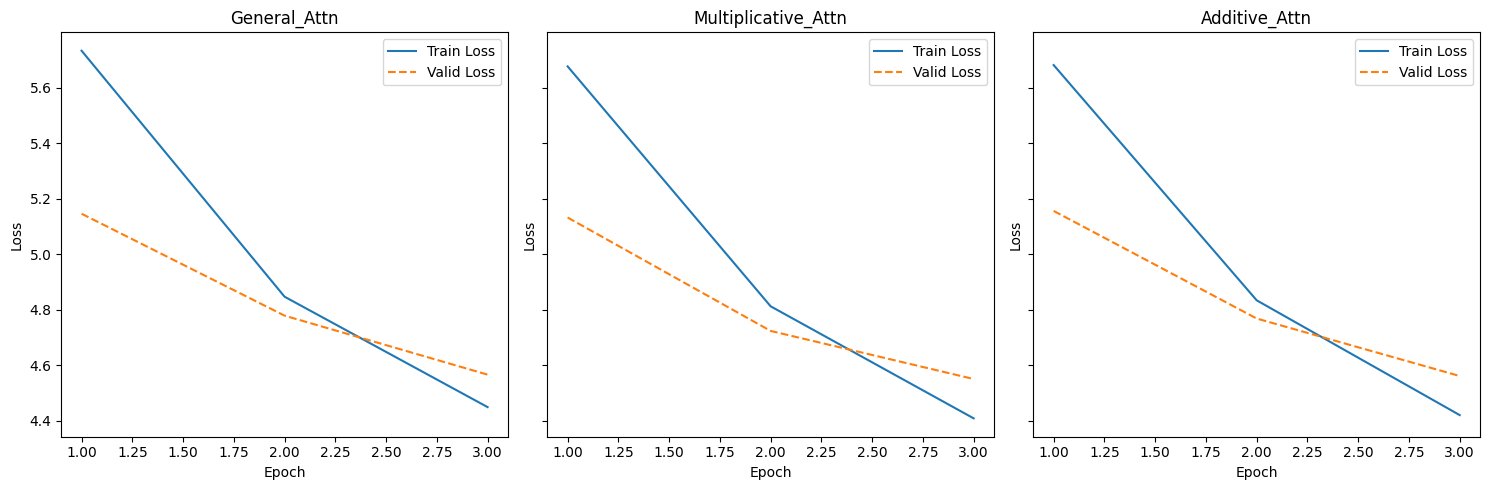

In [55]:
from tabulate import tabulate
import matplotlib.pyplot as plt
import torch
import math
import time

# Assuming you've defined train, evaluate, epoch_time functions, and have necessary imports

def calculate_average(values):
    """Calculate the average of a list of numeric values."""
    return sum(values) / len(values) if values else 0

def print_performance_table(data, headers, title=""):
    """Prints a table of performance data with a given title."""
    print(f"\n{title}\n")
    print(tabulate(data, headers=headers, tablefmt="grid"))

def analyze_and_print_results(attn_result):
    """Analyzes and prints results for each attention type in a tabular format."""
    performance_data, time_data, test_results_data = [], [], []
    
    for attn_type, metrics in attn_result.items():
        # Analyze performance metrics
        lowest_val_loss_epoch = lower_validation_loss(metrics['valid_losses'])
        lowest_val_loss = min(metrics['valid_losses'])
        avg_epoch_time = calculate_average(metrics['epoch_times'])
        
        performance_data.append([attn_type, lowest_val_loss_epoch, f"{lowest_val_loss:.3f}"])
        
        # Analyze computation time
        time_data.append([attn_type, f"{avg_epoch_time:.3f} seconds"])
        
        # Prepare for test evaluation
        test_loss = evaluate(models[attn_type], test_loader, criterion, len(test_loader))
        test_ppl = math.exp(test_loss)
        test_results_data.append([attn_type, len(test_loader.dataset), f"{test_loss:.3f}", f"{test_ppl:.3f}"])

    # Print tables
    print_performance_table(performance_data, ["Attention Type", "Epoch with Lowest Validation Loss", "Lowest Validation Loss"], "Performance Metrics")
    print_performance_table(time_data, ["Attention Type", "Average Epoch Time"], "Computational Efficiency")
    print_performance_table(test_results_data, ["Attention Type", "Number of Test Data", "Test Loss", "Test PPL"], "Test Set Evaluation")

def plot_attention_losses(attn_result):
    """Plots training and validation losses for each attention mechanism."""
    fig, axs = plt.subplots(1, len(attn_result), figsize=(15, 5), sharey=True)
    
    if len(attn_result) == 1:  # Ensure axs is iterable for a single subplot scenario
        axs = [axs]
    
    for ax, (attn_type, data) in zip(axs, attn_result.items()):
        epochs = range(1, len(data['train_losses']) + 1)
        ax.plot(epochs, data['train_losses'], label='Train Loss')
        ax.plot(epochs, data['valid_losses'], label='Valid Loss', linestyle='--')
        ax.set_title(f"{attn_type}")
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

# Main function to run analysis, plotting, and evaluation
def run_analysis_and_evaluation():
    analyze_and_print_results(attn_result)
    plot_attention_losses(attn_result)

run_analysis_and_evaluation()


## 8. Attention

Let's display the attentions to understand how the source text links with the generated text

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties
import matplotlib.ticker as ticker

# Updated display function to visualize attention weights
def attention_disp(sentence, translation, attention):
    # Define a new font that supports Bangla characters
    bangla_font_path = './font/kalpurush.ttf'  
    bangla_font = FontProperties(fname=bangla_font_path)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    # Convert attention tensor to numpy array for plotting
    attention = attention.squeeze().cpu().detach().numpy()

    # Create the heatmap for attention weights
    cax = ax.matshow(attention, cmap='coolwarm')

    # Enhance tick labels for clarity and apply Bangla font
    ax.tick_params(labelsize=15)  # Slightly larger for readability

    # Setting tick labels with an initial empty entry for alignment
    ax.set_xticklabels([''] + sentence, rotation=45, fontproperties=bangla_font)
    ax.set_yticklabels([''] + translation, fontproperties=bangla_font)

    # Set major locators to show each tick per token
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()


In [96]:
# Function to generate and display attention plot for given sentences
def attention_plot(model, src_sentence, trg_sentence, src_lang, trg_lang, device):
    # Transform and prepare source and target text for model input
    src_text = text_transform[src_lang](src_sentence).to(device)
    trg_text = text_transform[trg_lang](trg_sentence).to(device)

    src_text = src_text.reshape(1, -1)  # Adjust shape for single instance
    trg_text = trg_text.reshape(1, -1)

    # Ensure model is in evaluation mode
    model.eval()
    with torch.no_grad():
        # Generate output and attention weights without teacher forcing
        output, attentions = model(src_text, trg_text)

    # Process model output for visualization
    output = output.squeeze(0).to(torch.int64)[1:]  # Remove batch dimension and sos token
    output_max = output.argmax(1)  # Get most likely token indices
    mapping = vocab_transform[trg_lang].get_itos()  # Index to token mapping

    # Extract attention weights for the first layer and head
    attention = attentions[0, 0, :, :]

    # Prepare tokens for source and generated translation
    src_tokens = ['<sos>'] + token_transform[src_lang](src_sentence) + ['<eos>']
    trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]

    # Display the attention matrix using the custom function
    attention_disp(src_tokens, trg_tokens, attention)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_32536\2013236318.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, rotation=45, fontproperties=bangla_font)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_32536\2013236318.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + translation, fontproperties=bangla_font)


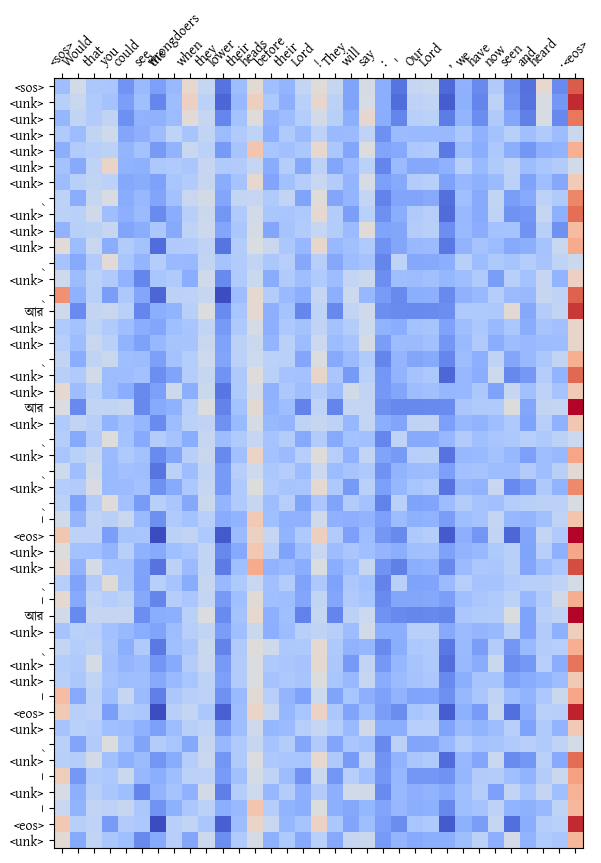

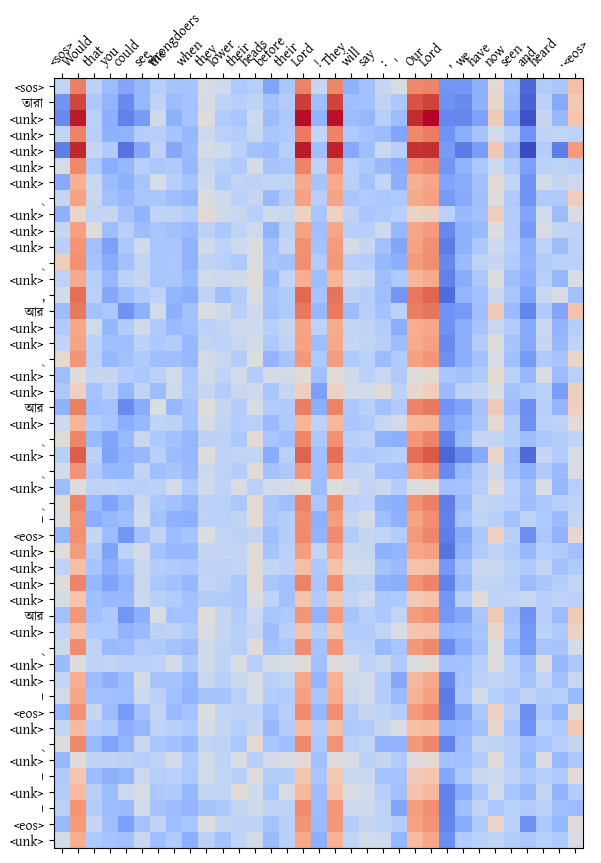

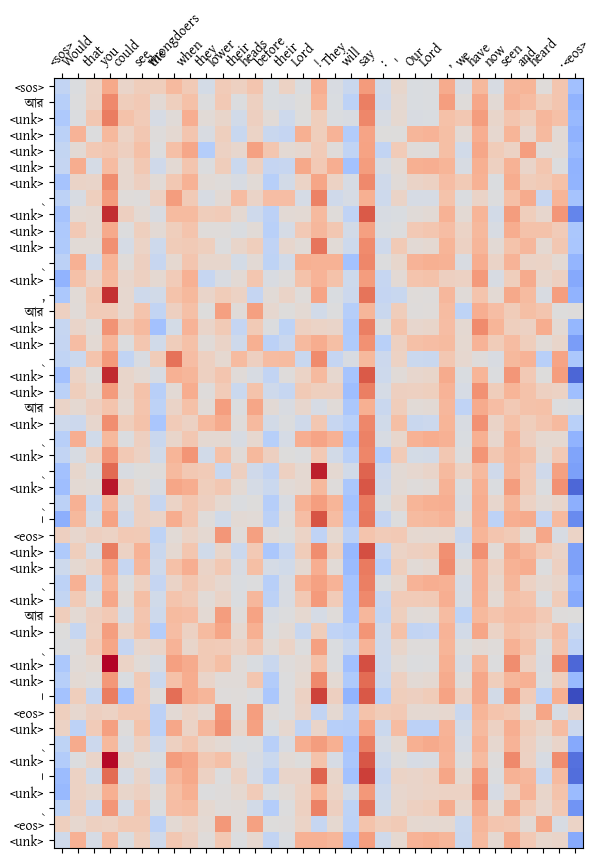

In [97]:
# Iterate over each model and generate attention plots
for attn_type, model in models.items():
    # Load saved parameters and state
    params, state = torch.load(f'./Models/{attn_type}_{model.__class__.__name__}.pt')
    
    # Initialize model with loaded parameters and state
    model = Seq2SeqTransformer(**params, device=device).to(device)
    model.load_state_dict(state)

    # Translate a sample sentence (you can change this sentence as needed)
    src_sentence = test_data[200]['en']
    trg_sentence = test_data[200]['bn']
    # print(src_sentence, trg_sentence)
    
    # Generate attention plot
    attention_plot(model, src_sentence, trg_sentence, SRC_LANGUAGE, TRG_LANGUAGE, device)

## 9. Save Model and Inference


In [100]:
# Data Loading and Configuration Setup

# Vocabulary Loading
# Load the previously saved vocabulary mappings from 'vocab.pt'
vocab_transform = torch.load('./models/vocab.pt')
print("Vocabulary loaded successfully.")

# Model Configuration File
# Read the model configuration from 'model_config.json'
config_file_path = './Models/model_config.json'
with open(config_file_path, 'r') as config_file:
    config = json.load(config_file)
print("Model configuration loaded successfully.")

# Configuration Assignment
# Assign loaded configuration values to respective variables
input_dim = config['input_dim']
output_dim = config['output_dim']
batch_size = config['batch_size']
lr = config['lr']
hid_dim = config['hid_dim']
enc_layers = config['enc_layers']
dec_layers = config['dec_layers']
enc_heads = config['enc_heads']
dec_heads = config['dec_heads']
enc_pf_dim = config['enc_pf_dim']
dec_pf_dim = config['dec_pf_dim']
enc_dropout = config['enc_dropout']
dec_dropout = config['dec_dropout']
SRC_PAD_IDX = config['SRC_PAD_IDX']
TRG_PAD_IDX = config['TRG_PAD_IDX']

# Variable Usage
# At this point, the loaded configuration values can be used to:
# - Initialize model with the specified architecture parameters
# - Set up training hyperparameters, optimizers, and loss functions for further training or inference

# Print Confirmation
print("Model configuration variables have been successfully assigned.")
# Printing a sample variable to verify the successful loading and assignment
print(f"Input dimension: {input_dim}, Output dimension: {output_dim}")


Vocabulary loaded successfully.
Model configuration loaded successfully.
Model configuration variables have been successfully assigned.
Input dimension: 2087, Output dimension: 2540


In [120]:

# Ensure necessary classes and functions like Encoder, Decoder, Seq2SeqTransformer,
# and initialize_weights are defined prior to executing this block.

# Specifying the types of attention mechanisms to experiment with.
attn_type_list = ['General_Attn', 'Multiplicative_Attn', 'Additive_Attn']

# A dictionary for storing model instances, keyed by their attention type.
# This facilitates easy access and management of different model configurations.
initialized_models = {}

# Iteratively initializing models for each specified attention type.
for attn_type in attn_type_list:
    print(f"\n***** Initializing Model with {attn_type} *****\n")
    
    # Setting up the encoder component of the Seq2Seq model with the current attention type.
    enc = Encoder(input_dim,
                  hid_dim,
                  enc_layers,
                  enc_heads,
                  enc_pf_dim,
                  enc_dropout,
                  device,
                  attn_type
                  )
    
    # Setting up the decoder component similarly.
    dec = Decoder(output_dim,
                  hid_dim,
                  dec_layers,
                  dec_heads,
                  dec_pf_dim,
                  enc_dropout,
                  device,
                  attn_type)
    
    # Assembling the Seq2Seq model using the initialized encoder and decoder.
    model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

    
    # Applying a predefined function to initialize model weights.
    model.apply(initialize_weights)
    
    # Storing the freshly initialized model for the current attention mechanism.
    initialized_models[attn_type] = model
    
    # Outputting the total number of trainable parameters in the model for reference.
    print(f"Model '{attn_type}' initialized with {sum(p.numel() for p in model.parameters() if p.requires_grad)} trainable parameters.")



***** Initializing Model with General_Attn *****

Model 'General_Attn' initialized with 6046956 trainable parameters.

***** Initializing Model with Multiplicative_Attn *****

Model 'Multiplicative_Attn' initialized with 6075765 trainable parameters.

***** Initializing Model with Additive_Attn *****

Model 'Additive_Attn' initialized with 6075765 trainable parameters.


In [115]:
# Dictionary to store loaded models
loaded_models = {}

# Loop over each attention type
for attn_type, model_path in models.items():
    print(f"\nLoading model for {attn_type}")
    # Load model parameters and state
    params, state = torch.load(f"./Models/{attn_type}_Seq2SeqTransformer.pt", map_location=device)
    
    # Create a new Seq2SeqTransformer model with loaded parameters
    model = Seq2SeqTransformer(**params, device=device)
    
    # Load the state dictionary
    model.load_state_dict(state)
    
    # Set the model to evaluation mode
    model.eval()
    
    # Store the loaded model in the dictionary with attention type as key
    loaded_models[attn_type] = model

    print(f"Model for {attn_type} loaded successfully.")

# Now 'loaded_models' contains all our models loaded from the saved files


Loading model for General_Attn
Model for General_Attn loaded successfully.

Loading model for Multiplicative_Attn
Model for Multiplicative_Attn loaded successfully.

Loading model for Additive_Attn
Model for Additive_Attn loaded successfully.


In [124]:
# Dictionary to organize models loaded from disk, keyed by their attention mechanism type.
# This facilitates straightforward access to different models for comparison or usage.
loaded_models = {}

# Iterating through each attention type and its corresponding model file path.
# Note: This assumes 'models' contains paths or identifiers for locating saved model states,
# which might require adjustment based on the actual content of 'models'.
for attn_type, _ in initialized_models.items():
    print(f"\nAttempting to load model configured with '{attn_type}' attention")

    # Constructing the file path to the saved model state.
    params, state = torch.load(f"./models/{attn_type}_Seq2SeqTransformer.pt", map_location=device)
    
    # Ensure the model file exists before attempting to load.
    if os.path.exists(model_path):
        # Loading the model parameters and state dictionary saved earlier.
        # Note: 'torch.load' directly returns the saved object, so the unpacking might need adjustment.
        model = Seq2SeqTransformer(**params, device=device)

        # Loading the saved state dictionary into the model.
        model.load_state_dict(state)


        # Switching the model to evaluation mode to disable dropout layers and batch normalization.
        model.eval()

        # Storing the loaded model for easy access.
        loaded_models[attn_type] = model

        print(f"Model configured with '{attn_type}' attention loaded successfully.")
    else:
        print(f"Model file '{model_path}' not found. Skipping loading for '{attn_type}' attention.")

# The 'loaded_models' dictionary now contains all the models successfully loaded and ready for use.



Attempting to load model configured with 'General_Attn' attention
Model configured with 'General_Attn' attention loaded successfully.

Attempting to load model configured with 'Multiplicative_Attn' attention
Model configured with 'Multiplicative_Attn' attention loaded successfully.

Attempting to load model configured with 'Additive_Attn' attention
Model configured with 'Additive_Attn' attention loaded successfully.


In [130]:
def translate_sentence(sentence, src_vocab_transform, trg_vocab_transform, model, device, max_len=50):
    """
    Translates a given sentence from the source language to the target language using a specified model.
    
    Parameters:
    - sentence (str): The sentence in the source language to be translated.
    - src_vocab_transform (dict): A mapping from source language tokens to indices.
    - trg_vocab_transform (dict): A mapping from target language tokens to indices.
    - model (Seq2SeqTransformer): The trained sequence-to-sequence model for translation.
    - device (torch.device): The device (CPU or GPU) on which the computation will be performed.
    - max_len (int): The maximum length of the translated sentence.
    
    Returns:
    - str: The translated sentence in the target language.
    """
    model.eval()  # Switch the model to evaluation mode.

    # Tokenize the input sentence and add start-of-sentence (<sos>) and end-of-sentence (<eos>) tokens.
    tokens = ['<sos>'] + [token.lower() for token in token_transform[SRC_LANGUAGE](sentence)] + ['<eos>']
    src_indexes = [src_vocab_transform[token] for token in tokens]

    # Convert the token indices to a tensor and add a batch dimension.
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    # Generate the source mask for the input tensor.
    src_mask = model.make_src_mask(src_tensor)

    # Forward pass through the encoder.
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
        trg_indexes = [trg_vocab_transform['<sos>']]  # Initialize the target sequence with <sos> token.

        for _ in range(max_len):
            trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
            trg_mask = model.make_trg_mask(trg_tensor)

            # Decode the target tensor to generate the next token in the sequence.
            output, _ = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
            pred_token = output.argmax(2)[:, -1].item()
            trg_indexes.append(pred_token)

            # Break the loop if the end-of-sentence token is generated.
            if pred_token == trg_vocab_transform['<eos>']:
                break

    # Convert the target indices back to tokens and join them to form the translated sentence.
    trg_tokens = [trg_vocab_transform.get_itos()[i] for i in trg_indexes]

    return ' '.join(trg_tokens[1:-1])  # Exclude the <sos> and <eos> tokens in the final sentence.

# Demonstrate translating sentences using each loaded model.
random_samples = random.sample(list(enumerate(test_data)), 10)
for index, sample in random_samples:
    src_sentence = sample['en']
    print(f"\nIndex: {index}, Original text: {src_sentence}\n")

    for attn_type, model in loaded_models.items():
        translation = translate_sentence(src_sentence, vocab_transform[SRC_LANGUAGE], vocab_transform[TRG_LANGUAGE], model, device)
        print(f"Translated with {attn_type} attention: {translation}")

    print("-" * 50)  # Print a separator for readability.



Index: 293, Original text: Say , " Not equal are the evil and the good , although the abundance of evil might impress you . " So fear Allah , O you of understanding , that you may be successful .

Translated with General_Attn attention: আর <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ।
Translated with Multiplicative_Attn attention: আর তারা <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk>
Translated with Additive_Attn attention: আর তারা <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk> ্ <unk>
--------------------------------------------------

Index: 235, Original text: dc-qt

Trans